# A/A/B тестирование среди пользователей дейтингового приложения

## Описание проекта

Представьте, что вы работаете в крупном дейтинговом приложении.
Помимо базовых функций, в приложении также имеется премиум-подписка, которая дает доступ к ряду важных дополнительных возможностей. Был проведен A/B тест, в рамках которого для новых пользователей из нескольких стран была изменена стоимость премиум-подписки* при покупке через две новые платежные системы. При этом стоимость пробного периода оставалась прежней.

Проверьте:

1. Был ли эксперимент успешен в целом.
2. Проанализируйте, имеет ли нововведение смысл среди каких-либо конкретных групп пользователей.

*Деньги за подписку списываются ежемесячно до тех пор, пока пользователь её не отменит.

## Изучение данных и исследовательский анализ данных

In [1]:
# Импортируем библиотеки
from IPython.display import display
import pandas as pd
from scipy import stats
import scipy.stats as ss
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from tqdm.auto import tqdm
import seaborn as sns
from io import BytesIO
import requests
from scipy.stats import norm

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Загрузка данных из Яндекс.Диска
def get_disk_data(data_url):
    api_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    response = requests.get(api_url + 'public_key=' + data_url)
    request = requests.get(response.json()['href'])
    data = request.content
    df = pd.read_csv(BytesIO(data), sep=';')
    return df

In [3]:
# Прочитаем файлы
users_test = get_disk_data('https://disk.yandex.ru/d/4XXIME4osGrMRA')
users_control_1 = get_disk_data('https://disk.yandex.ru/d/yJFydMNNGkEKfg')
users_control_2 = get_disk_data('https://disk.yandex.ru/d/br6KkQupzzTGoQ')
transactions_test = get_disk_data('https://disk.yandex.ru/d/gvCWpZ55ODzs2g')
transactions_control_1 = get_disk_data('https://disk.yandex.ru/d/VY5W0keMX5TZBQ')
transactions_control_2 = get_disk_data('https://disk.yandex.ru/d/th5GL0mGOc-qzg')

In [4]:
# Напишем функцию для извлечения однотипной информации из датасетов
def get_info(data):
    display("Общая информация по датасету", data.info())
    display("Наличие пропусков в датасете", data.isna().sum())
    display("Наличие дубликатов в датасете", data.duplicated().sum())

In [5]:
# Посмотрим на таблицу с пользователями тестовой группы
get_info(users_test)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4308 entries, 0 to 4307
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   uid               4308 non-null   int64  
 1   age               4308 non-null   int64  
 2   attraction_coeff  4308 non-null   int64  
 3   coins             49 non-null     float64
 4   country           4308 non-null   object 
 5   visit_days        2978 non-null   object 
 6   gender            4308 non-null   int64  
 7   age_filter_start  4308 non-null   int64  
 8   age_filter_end    4308 non-null   int64  
 9   views_count       4308 non-null   int64  
 10  was_premium       408 non-null    float64
 11  is_premium        157 non-null    float64
 12  total_revenue     4308 non-null   int64  
dtypes: float64(3), int64(8), object(2)
memory usage: 437.7+ KB


'Общая информация по датасету'

None

'Наличие пропусков в датасете'

uid                    0
age                    0
attraction_coeff       0
coins               4259
country                0
visit_days          1330
gender                 0
age_filter_start       0
age_filter_end         0
views_count            0
was_premium         3900
is_premium          4151
total_revenue          0
dtype: int64

'Наличие дубликатов в датасете'

0

In [6]:
# Посмотрим на таблицу с пользователями первой контрольной группы
get_info(users_control_1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4340 entries, 0 to 4339
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   uid               4340 non-null   int64  
 1   age               4340 non-null   int64  
 2   attraction_coeff  4340 non-null   int64  
 3   coins             60 non-null     float64
 4   country           4340 non-null   object 
 5   visit_days        3016 non-null   object 
 6   gender            4340 non-null   int64  
 7   age_filter_start  4340 non-null   int64  
 8   age_filter_end    4340 non-null   int64  
 9   views_count       4340 non-null   int64  
 10  was_premium       436 non-null    float64
 11  is_premium        192 non-null    float64
 12  total_revenue     4340 non-null   int64  
dtypes: float64(3), int64(8), object(2)
memory usage: 440.9+ KB


'Общая информация по датасету'

None

'Наличие пропусков в датасете'

uid                    0
age                    0
attraction_coeff       0
coins               4280
country                0
visit_days          1324
gender                 0
age_filter_start       0
age_filter_end         0
views_count            0
was_premium         3904
is_premium          4148
total_revenue          0
dtype: int64

'Наличие дубликатов в датасете'

0

In [7]:
# Посмотрим на таблицу с пользователями второй контрольной группы
get_info(users_control_2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4264 entries, 0 to 4263
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   uid               4264 non-null   int64  
 1   age               4264 non-null   int64  
 2   attraction_coeff  4264 non-null   int64  
 3   coins             61 non-null     float64
 4   country           4264 non-null   object 
 5   visit_days        2900 non-null   object 
 6   gender            4264 non-null   int64  
 7   age_filter_start  4264 non-null   int64  
 8   age_filter_end    4264 non-null   int64  
 9   views_count       4264 non-null   int64  
 10  was_premium       411 non-null    float64
 11  is_premium        191 non-null    float64
 12  total_revenue     4264 non-null   int64  
dtypes: float64(3), int64(8), object(2)
memory usage: 433.2+ KB


'Общая информация по датасету'

None

'Наличие пропусков в датасете'

uid                    0
age                    0
attraction_coeff       0
coins               4203
country                0
visit_days          1364
gender                 0
age_filter_start       0
age_filter_end         0
views_count            0
was_premium         3853
is_premium          4073
total_revenue          0
dtype: int64

'Наличие дубликатов в датасете'

0

In [8]:
# Посмотрим на таблицу с платежами тестовой группы
get_info(transactions_test)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 273 entries, 0 to 272
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   uid           273 non-null    int64 
 1   country       273 non-null    object
 2   joined_at     273 non-null    object
 3   paid_at       273 non-null    object
 4   revenue       273 non-null    int64 
 5   payment_id    273 non-null    int64 
 6   from_page     273 non-null    object
 7   product_type  273 non-null    object
dtypes: int64(3), object(5)
memory usage: 17.2+ KB


'Общая информация по датасету'

None

'Наличие пропусков в датасете'

uid             0
country         0
joined_at       0
paid_at         0
revenue         0
payment_id      0
from_page       0
product_type    0
dtype: int64

'Наличие дубликатов в датасете'

7

In [9]:
# Посмотрим на таблицу с платежами первой контрольной группы
get_info(transactions_control_1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1007 entries, 0 to 1006
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   uid           377 non-null    float64
 1   country       377 non-null    object 
 2   joined_at     1007 non-null   object 
 3   paid_at       1007 non-null   object 
 4   revenue       377 non-null    float64
 5   payment_id    377 non-null    float64
 6   from_page     377 non-null    object 
 7   product_type  377 non-null    object 
dtypes: float64(3), object(5)
memory usage: 63.1+ KB


'Общая информация по датасету'

None

'Наличие пропусков в датасете'

uid             630
country         630
joined_at         0
paid_at           0
revenue         630
payment_id      630
from_page       630
product_type    630
dtype: int64

'Наличие дубликатов в датасете'

650

In [10]:
# Посмотрим на таблицу с платежами второй контрольной группы
get_info(transactions_control_2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 328 entries, 0 to 327
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   uid           328 non-null    int64 
 1   country       328 non-null    object
 2   joined_at     328 non-null    object
 3   paid_at       328 non-null    object
 4   revenue       328 non-null    int64 
 5   payment_id    328 non-null    int64 
 6   from_page     328 non-null    object
 7   product_type  328 non-null    object
dtypes: int64(3), object(5)
memory usage: 20.6+ KB


'Общая информация по датасету'

None

'Наличие пропусков в датасете'

uid             0
country         0
joined_at       0
paid_at         0
revenue         0
payment_id      0
from_page       0
product_type    0
dtype: int64

'Наличие дубликатов в датасете'

5

**Вывод**: 
1. в таблицах с платежами столбцы с датами типа object, необходимо привести их к формату даты. В таблице с платежами первой контрольной группы столбец uid формата float, позже приведем его к int 64.
2. в таблицах по пользователям  имеются пропуски в столбцах coins(скорей всего, нет внутренней валюты у пользователя), visit_days(вероятно, не посещал приложение после регистрации), was_premium (вероятно, не был премиальным) ,is_premium (вероятно, не премиальный сейчас). Заменим эти пропуски на 0.
3. в таблице по платежам у первой контрольной группы имеется много пропусков в столбцах uid, country, revenue, payment_id, from_page, product_type (вероятно, произошла техническая ошибка при сборе данных). Чтобы дальнейший анализ был возможен - удалим строки, в которых пропущены uid.

In [11]:
# Заменим пропуски в таблицах о пользователях на нули
users_test = users_test.fillna(0)
users_control_1 = users_control_1.fillna(0)
users_control_2 = users_control_2.fillna(0)

In [12]:
# Удалим строки, в которых пропущены uid
transactions_control_1 = transactions_control_1.dropna(subset=['uid'])

In [13]:
# Приведем столбцы с датой к формату даты, столбец с uid к int64
transactions_test['paid_at'] = pd.to_datetime(transactions_test['paid_at'], format='%Y-%m-%d %H:%M:%S.%f')
transactions_test['joined_at'] = pd.to_datetime(transactions_test['joined_at'], format='%Y-%m-%d %H:%M:%S.%f')
transactions_control_1['paid_at'] = pd.to_datetime(transactions_control_1['paid_at'], format='%Y-%m-%d %H:%M:%S.%f')
transactions_control_1['joined_at'] = pd.to_datetime(transactions_control_1['joined_at'], format='%Y-%m-%d %H:%M:%S.%f')
transactions_control_2['paid_at'] = pd.to_datetime(transactions_control_2['paid_at'], format='%Y-%m-%d %H:%M:%S.%f')
transactions_control_2['joined_at'] = pd.to_datetime(transactions_control_2['joined_at'], format='%Y-%m-%d %H:%M:%S.%f')
transactions_control_1['uid'] = transactions_control_1['uid'].astype('int64')
display(transactions_test.dtypes, transactions_control_1.dtypes, transactions_control_2.dtypes)

uid                      int64
country                 object
joined_at       datetime64[ns]
paid_at         datetime64[ns]
revenue                  int64
payment_id               int64
from_page               object
product_type            object
dtype: object

uid                      int64
country                 object
joined_at       datetime64[ns]
paid_at         datetime64[ns]
revenue                float64
payment_id             float64
from_page               object
product_type            object
dtype: object

uid                      int64
country                 object
joined_at       datetime64[ns]
paid_at         datetime64[ns]
revenue                  int64
payment_id               int64
from_page               object
product_type            object
dtype: object

In [14]:
# Еще раз проверим на наличие дубликатов
display(users_test.duplicated().sum())
display(users_control_1.duplicated().sum())
display(users_control_2.duplicated().sum())
display(transactions_test.duplicated().sum())
display(transactions_control_1.duplicated().sum())
display(transactions_control_2.duplicated().sum())

0

0

0

7

21

5

**Вывод**: в таблицах с платежами имеются дубликаты, пока не будем удалять их, попробуем разобраться.

## Проверка выборок

In [15]:
# Посмотрим на количество уникальных пользователей в группах
display(users_test.uid.nunique())
display(users_control_1.uid.nunique())
display(users_control_2.uid.nunique())

4308

4340

4264

In [16]:
# Проверим, сколько уникальных пользователей в таблицах по платежам
display(transactions_test.uid.nunique())
display(transactions_control_1.uid.nunique())
display(transactions_control_2.uid.nunique())

146

193

187

Теперь найдем период проведения теста, ориентируясь на даты платежей.

In [17]:
# Найдем минимальную и максимальную даты покупок в тестовой группе
display(transactions_test.paid_at.min(), transactions_test.paid_at.max())

Timestamp('2017-01-11 04:37:00')

Timestamp('2017-12-11 22:06:00')

In [18]:
# Найдем минимальную и максимальную даты покупок в контрольной группе 1
display(transactions_control_1.paid_at.min(), transactions_control_1.paid_at.max())

Timestamp('2016-12-14 16:16:00')

Timestamp('2017-12-11 21:57:00')

In [19]:
# Найдем минимальную и максимальную даты покупок в контрольной группе 2
display(transactions_control_2.paid_at.min(), transactions_control_2.paid_at.max())

Timestamp('2017-01-11 05:34:00')

Timestamp('2017-12-11 23:28:00')

**Вывод**: Даты проведения теста в тестовой группе и в контрольной группе 2 совпадают (с 11.01.2017 по 11.12.2017), в контрольной группе 1 есть данные о платежах, совершенных ранее 11.01.2017.

In [20]:
# Посмотрим, сколько платежей совершено ранее 11.01.2017 в контрольной группе 1
transactions_control_1.query('paid_at < "2017-01-11 00:00:00"')

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
65,960936960,Russian Federation,2015-01-19 11:49:00,2016-12-14 17:30:00,26.0,0.0,refund_VP,other_type
101,960936960,Russian Federation,2015-01-19 11:49:00,2016-12-14 17:35:00,637.0,0.0,refung_AP,other_type
224,960936960,Russian Federation,2015-01-19 11:49:00,2016-12-14 16:16:00,143.0,0.0,refund_WP,other_type


In [21]:
# Поскольку таких платежей всего 3 и у одного и того же пользователя, то исключим его из обеих таблиц
transactions_control_1 = transactions_control_1.query('uid != 960936960')
users_control_1 = users_control_1.query('uid != 960936960')

In [22]:
# Посмотрим, соответствует ли выручка в таблицах с пользователями выручке в таблицах с платежами
display(users_test.total_revenue.sum() == transactions_test.revenue.sum())
display(users_control_1.total_revenue.sum() == transactions_control_1.revenue.sum())
display(users_control_2.total_revenue.sum() == transactions_control_2.revenue.sum())

False

False

True

In [23]:
# Найдем пользователей, у которых не сошлась выручка
# для этого сначала проведем группировку по пользователям из таблицы с платежами и посчитаем общую выручку
# далее соединим эти данные с таблицей пользователй по uid и отсортируем тех, у кого не сошлась выручка, 
# отбросив данные без выручки
revenue_test = transactions_test.groupby('uid', as_index=False).revenue.sum()
users_test_revenue = users_test.merge(revenue_test, on='uid', how='left') 
users_test_revenue.query('(total_revenue != revenue) & (revenue >0)')

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,revenue
2070,892275462,31,310,0.0,France,"1,2,3,4,5,9,13,15,16",1,36,68,58,1.0,1.0,14885,58968.0


In [24]:
# Посмотрим подробнее данные о платежах данного пользователя
transactions_test.query('uid == 892275462')

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
64,892275462,France,2017-10-17 05:56:00,2017-02-11 18:24:00,44083,19,coins_popup,other_type
154,892275462,France,2017-10-17 05:56:00,2017-10-20 17:00:00,14885,68,super_popup,other_type


In [25]:
# Проделаем то же самое с контрольной группой
revenue_control_1 = transactions_control_1.groupby('uid', as_index=False).revenue.sum()
users_c_1_revenue = users_control_1.merge(revenue_control_1, on='uid', how='left')
users_c_1_revenue.query('(total_revenue != revenue) & (revenue >0)')

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,revenue
3369,892355163,40,640,0.0,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1...",1,25,60,700,1.0,0.0,0,30264.0


In [26]:
transactions_control_1.query('uid == 892355163')

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
303,892355163,United States of America,2017-10-15 18:45:00,2017-10-16 09:52:00,30264.0,68.0,super_popup,other_type


**Вывод**: изучив данные пользователей, у которых не сошлась выручка мы можем предположить о том, что в таблицах с пользователями (судя по сумме) не были учтены некоторые платежи. Оставим выручку, которую посчитали в таблицах с платежами.

In [27]:
users_test.loc[users_test['uid'] == 892275462, 'total_revenue'] = 58968
users_control_1.loc[users_control_1['uid'] == 892355163, 'total_revenue'] = 30264

In [28]:
# Проверяем
display(users_test.total_revenue.sum() == transactions_test.revenue.sum(),
        users_control_1.total_revenue.sum() == transactions_control_1.revenue.sum())

True

True

**Вывод**: теперь выручка пользователей сходится, поэтому несмотря на наличие дубликатов не будем их удалять. Они могут быть связаны с тем, что во времени оплаты не учтены секунды или с тем, что оплата производилась с разных устройств одновременно.

In [29]:
# Проверим на наличие пользователей одновременно в нескольких тестах среди таблиц с пользователями
users_t = users_test.uid.unique()
users_c_1 = users_control_1.uid.unique()

# Сравним группы тестовую и контрольную 1
display(users_control_1.query('uid in @users_t').uid.count())
# Сравним группы тестовую и контрольную 2
display(users_control_2.query('uid in @users_t').uid.count())
# Сравним две контрольные группы
display(users_control_2.query('uid in @users_c_1').uid.count())

0

0

0

In [30]:
# Проверим на наличие пользователей одновременно в нескольких тестах среди таблиц с платежами
a = transactions_test.uid.unique()
b = transactions_control_1.uid.unique()

# Сравним группы тестовую и контрольную 1
display(transactions_control_1.query('uid in @a').uid.count())
# Сравним группы тестовую и контрольную 2
display(transactions_control_2.query('uid in @a').uid.count())
# Сравним две контрольные группы
display(transactions_control_2.query('uid in @b').uid.count())

0

0

0

**Вывод:** пользователи во всех трех группах не перекликаются, как и должно быть в эксперименте.

In [31]:
# Посчитаем, из скольких уникальных стран пользователи в разных группах
display(users_test.country.nunique())
display(users_control_1.country.nunique())
display(users_control_2.country.nunique())

51

40

45

In [32]:
# Посчитаем, из скольких стран есть пользователи во всех группах
countries_test = users_test.country.unique()
countries_control_1 = users_control_1.country.unique()

display(users_control_2.query('country in @countries_test & country in @countries_control_1').country.nunique())


25

**Вывод**: в задании указано, что для новых пользователей из нескольких стран была изменена стоимость премиум-подписки, однако, не указано из каких именно. Мы выявили, что пользователи из 25 стран есть во всех трех группах, тогда как в разных группах пользователи из более чем 40 стран. Чтобы группы были однородные, оставим только те страны, пользователи из которых есть во всех группах.

In [33]:
# Cоздадим список этих 25 стран
countries_in_all_groups = list(users_control_2.query('country in @countries_test & country in @countries_control_1')
                               .country.unique())

In [34]:
# Оставим пользователй из этих стран
users_test = users_test.query('country in @countries_in_all_groups')
users_control_1 = users_control_1.query('country in @countries_in_all_groups')
users_control_2 = users_control_2.query('country in @countries_in_all_groups')

In [35]:
# Посмотрим теперь на количество оставшихся уникальных пользователей в группах
display(users_test.uid.nunique())
display(users_control_1.uid.nunique())
display(users_control_2.uid.nunique())

4271

4318

4238

**Вывод**: в тестовой группе остались 4271 пользователя (было 4308), в контрольной группе 1 стало 4318 пользователей (было 4346), в контрольной группе 2 стало 4238 пользователей (было 4264). Таким образом, из неперекликающихся стран мало пользователей, которыми можно пренебречь. Получившиеся данные пригодны для дальнейшего анализа.

In [36]:
# Посчитаем, сколько новых пользователей, исходя из того, что их дата регистрации будет позже даты начала эксперимента
display(transactions_test.query('joined_at > "2017-01-11 00:00:00"').shape)
display(transactions_control_1.query('joined_at > "2017-01-11 00:00:00"').shape)
display(transactions_control_2.query('joined_at > "2017-01-11 00:00:00"').shape)

(273, 8)

(374, 8)

(328, 8)

**Вывод:** в тестовой группе 273 новых пользователя, в контрольной группе 1 - 374 пользователя, в контрольной группе 2 - 328 пользователей. Данные сопоставимы для проведения эксперимента.

In [37]:
# посмотрим, минимальный возраст пользователей
display(users_test.age.min())
display(users_control_1.age.min())
display(users_control_2.age.min())

16

16

16

In [38]:
# посмотрим, максимальный возраст пользователей
display(users_test.age.max())
display(users_control_1.age.max())
display(users_control_2.age.max())

99

99

99

In [39]:
# посмотрим, сколько премиальных клиентов было
display(users_test.was_premium.value_counts())
display(users_control_1.was_premium.value_counts())
display(users_control_2.was_premium.value_counts())

0.0    3866
1.0     405
Name: was_premium, dtype: int64

0.0    3884
1.0     434
Name: was_premium, dtype: int64

0.0    3829
1.0     409
Name: was_premium, dtype: int64

In [40]:
# посмотрим, сколько премиальных клиентов сейчас
display(users_test.is_premium.value_counts())
display(users_control_1.is_premium.value_counts())
display(users_control_2.is_premium.value_counts())

0.0    4115
1.0     156
Name: is_premium, dtype: int64

0.0    4127
1.0     191
Name: is_premium, dtype: int64

0.0    4049
1.0     189
Name: is_premium, dtype: int64

**Вывод:** 
1. Минимальный возраст во всех группах -16 лет, максимальный во всех группах -99.
2. Премиальных клиентов было в тестовой группе 405, в контрольной группе 1 - 434, в контрольной 2 - 409. Данные сопоставимы.
3. Премиальных клиентов сейчас в тестовой группе 156, в контрольной группе 1 - 191, в контрольной 2 - 189. Данные сопоставимы.

In [41]:
# Посмотрим на распределение платежей по типу продукта
display(transactions_test.product_type.value_counts())
display(transactions_control_1.product_type.value_counts())
display(transactions_control_2.product_type.value_counts())

coins               106
premium_no_trial     76
trial_premium        62
other_type           29
Name: product_type, dtype: int64

coins               149
premium_no_trial    106
trial_premium        67
other_type           52
Name: product_type, dtype: int64

coins               124
premium_no_trial    107
trial_premium        53
other_type           44
Name: product_type, dtype: int64

**Вывод**: из данных видно, что распределение платежей по типу продукта во всех группах однородно.

In [42]:
# Объединим таблицы пользователей и платежей
# Перед объединением таблиц добавим колонку, определяющую к какой группе относится пользователь
users_test['group'] = 'test'
users_control_1['group'] = 'control_1'
users_control_2['group'] = 'control_2'
transactions_test['group'] = 'test'
transactions_control_1['group'] = 'control_1'
transactions_control_2['group'] = 'control_2'

In [43]:
# Соединим по отдельности всех пользователей и все платежи
all_users = pd.concat([users_test, users_control_1, users_control_2], ignore_index=True)
all_transactions = pd.concat([transactions_test, transactions_control_1, transactions_control_2], ignore_index=True)
# Вынесем отдельно столбец с подпиской premium_no_trial, где 0 -другая подписка, 1- premium_no_trial
all_transactions['premium_no_trial'] = np.where(all_transactions['product_type'] == 'premium_no_trial', 1, 0)

In [44]:
# Отберем данные из таблицы с платежами 
# Сгруппируем по пользователям и premium_no_trial, посчитаем выручку
transactions_uid_revenue = all_transactions.groupby(['uid', 'premium_no_trial'], as_index=False) \
                                           .agg({'revenue': 'sum'})

In [45]:
# Объединим получившиеся таблицы
data = all_users.merge(transactions_uid_revenue, how='left', on='uid').fillna(0)
data.head()

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,group,premium_no_trial,revenue
0,892309896,27,685,0.0,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,16,17",1,24,30,89,0.0,0.0,0,test,0.0,0.0
1,892044516,27,0,0.0,Germany,0,1,24,30,0,0.0,0.0,0,test,0.0,0.0
2,892185708,45,44,0.0,Israel,"1,3,4,6,7,8,10,11,12,13,14,15,16,17,18,19,20,2...",1,42,48,68,0.0,0.0,0,test,0.0,0.0
3,892130292,32,0,0.0,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12",1,29,35,0,0.0,0.0,0,test,0.0,0.0
4,891406035,27,1000,0.0,France,0,1,24,30,1,1.0,0.0,0,test,0.0,0.0


Text(0.5, 1.0, 'Распределение пользователей в группах по возрасту')

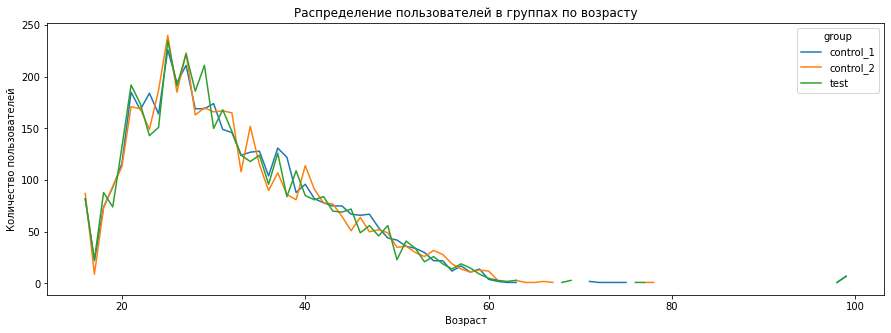

In [46]:
# Посмотрим на распределение пользователей в группах по возрасту
data.pivot_table(index='age', columns='group', values='uid', aggfunc='nunique').plot(figsize=(15, 5))
plt.xlabel('Возраст')
plt.ylabel('Количество пользователей')
plt.title('Распределение пользователей в группах по возрасту')

In [47]:
# Разобьем возраст пользователей на категории (у нас пользователи от 16 до 99 лет) 
def age_category(row):
    age = row['age']
    if 16 <= age <= 25:
        return "юные"
    elif 26 <= age <= 35:
        return "молодые"
    elif 36 <= age <= 45:
        return "средний возраст"
    elif 46 <= age <= 60:
        return "зрелые"
    else:
        return "пожилые" 
data['age_category'] = data.apply(age_category, axis=1) 

Text(0.5, 1.0, 'Распределение пользователей в группах по коэффициенту привлекательности')

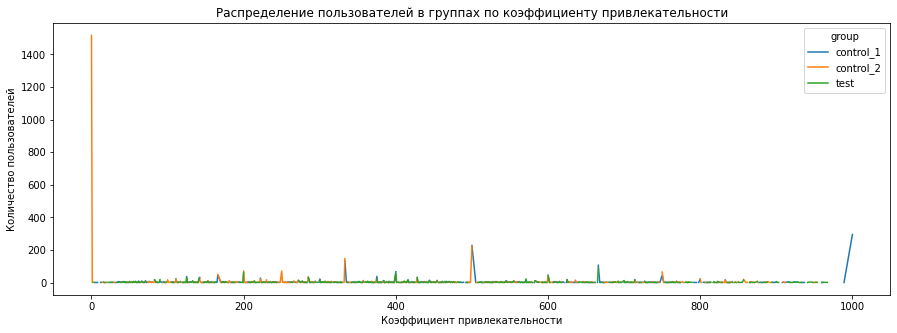

In [48]:
# Посмотрим на распределение пользователей в группах по коэффициенту привлекательности
data.pivot_table(index='attraction_coeff', columns='group', values='uid', aggfunc='nunique').plot(figsize=(15, 5))
plt.xlabel('Коэффициент привлекательности')
plt.ylabel('Количество пользователей')
plt.title('Распределение пользователей в группах по коэффициенту привлекательности')

Text(0.5, 1.0, 'Распределение пользователей в группах по полу')

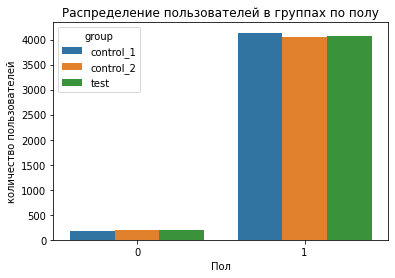

In [49]:
# Посмотрим на распределение пользователей в группах по полу
data_gender = data.groupby(['gender', 'group'], as_index=False).agg({'uid': 'nunique'})
sns.barplot(x='gender',
            y='uid',
            hue='group',
            data=data_gender)
plt.xlabel('Пол')
plt.ylabel('количество пользователей')
plt.title('Распределение пользователей в группах по полу')

Text(0.5, 1.0, 'Распределение пользователей в группах по странам')

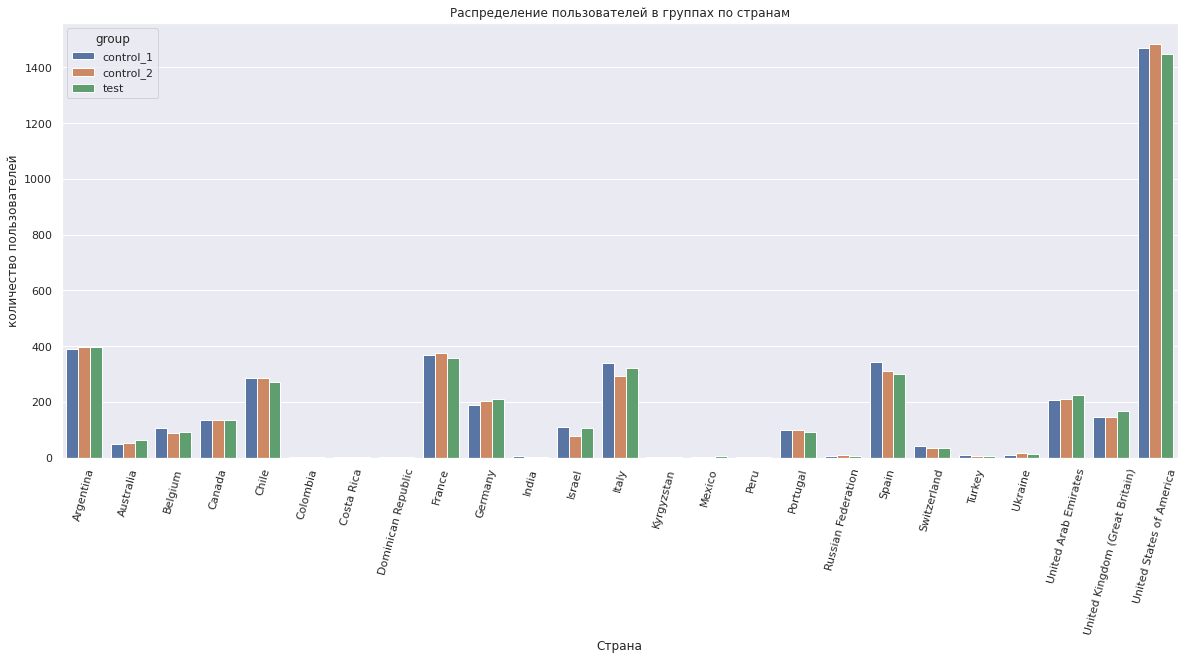

In [50]:
# Посмотрим на распределение пользователей в группах по странам
data_country = data.groupby(['country', 'group'], as_index=False).agg({'uid': 'nunique'})
sns.set(rc={"figure.figsize": (20, 8)})
sns.barplot(x='country',
            y='uid',
            hue='group',
            data=data_country)
plt.xticks(rotation=75)
plt.xlabel('Страна')
plt.ylabel('количество пользователей')
plt.title('Распределение пользователей в группах по странам')

**Вывод:** распределение пользователей в разбивке по возрасту, полу, странам, в целом, сопоставимо. В распределении пользователей в группах по коэффициенту привлекательности видим бОльшее количество пользователей с коэффициентом 0 во второй контрольной группе, с коэффициентом около 1000 - больше в первой контрольной группе, что может сказаться на результатах проведения теста.

**Общий вывод:**
1. Привели данные к нужным типам, обработали пропуски.
2. Выяснили, что тест проводился с 11.01.2017 по 11.12.2017.
3. Изучив данные пользователей, у которых не сошлась выручка мы предположили о том, что в таблицах с пользователями (судя по сумме) не были учтены некоторые платежи. Оставили выручку, которую посчитали в таблицах с платежами.
4. Выручка пользователей сошлась, поэтому несмотря на наличие дубликатов не стали их удалять. 
5. Проверили, что пользователи во всех трех группах не перекликаются.
6. Выявили, что пользователи из 25 стран есть во всех трех группах, тогда как в разных группах пользователи из более чем 40 стран. Чтобы группы были однородные, оставили только те страны, пользователи из которых есть во всех группах.
7. Посмотрели, что в тестовой группе 273 новых пользователя, в контрольной группе 1 - 374 пользователя, в контрольной группе 2 - 328 пользователей. Данные сопоставимы.
8. Минимальный возраст во всех группах -16 лет, максимальный во всех группах -99.
9. Премиальных клиентов было в тестовой группе 405, в контрольной группе 1 - 434, в контрольной 2 - 409. Данные сопоставимы.
10. Премиальных клиентов сейчас в тестовой группе 156, в контрольной группе 1 - 191, в контрольной 2 - 189. Данные сопоставимы.
11. Посмотрели, что распределение платежей по типу продукта во всех группах однородно.
12. Распределение пользователей в разбивке по возрасту, полу, странам, в целом, сопоставимо. В распределении пользователей в группах по коэффициенту привлекательности видим бОльшее количество пользователей с коэффициентом 0 во второй контрольной группе, с коэффициентом около 1000 - больше в первой контрольной группе, что может сказаться на результатах проведения теста.
13. Для дальнейшего анализа объединили все таблицы.

## А/А тест


Будем исследовать данные пользователей с подпиской premium_no_trial, т.к. именно сней произошли изменения согласно заданию.
В качестве целевых метрик будем использовать ARPU(средний доход на всех пользователей), ARPPU(доход на одного платящего пользователя) и CR (за конверсию принимаем покупку премиум-подписки).

In [51]:
# Посмотрим на количество наблюдений в двух группах
display(data[data['group'] == "control_1"].uid.nunique(),
        data[data['group'] == "control_2"].uid.nunique())

4318

4238

**ARPU**

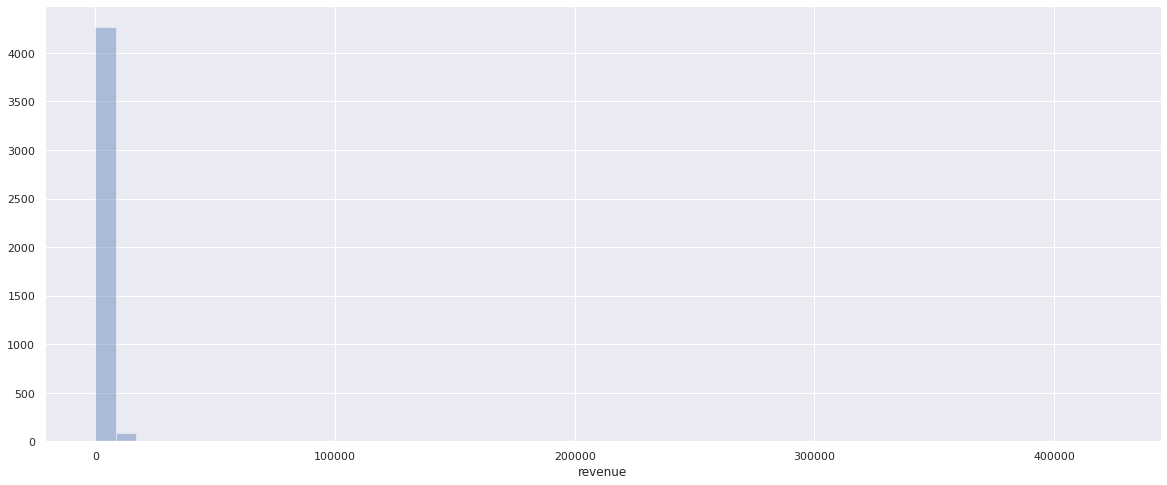

In [52]:
# Посмотрим на распределение в 1 контрольной группе
sns.distplot(data[data['group'] == "control_1"].revenue, kde=False)

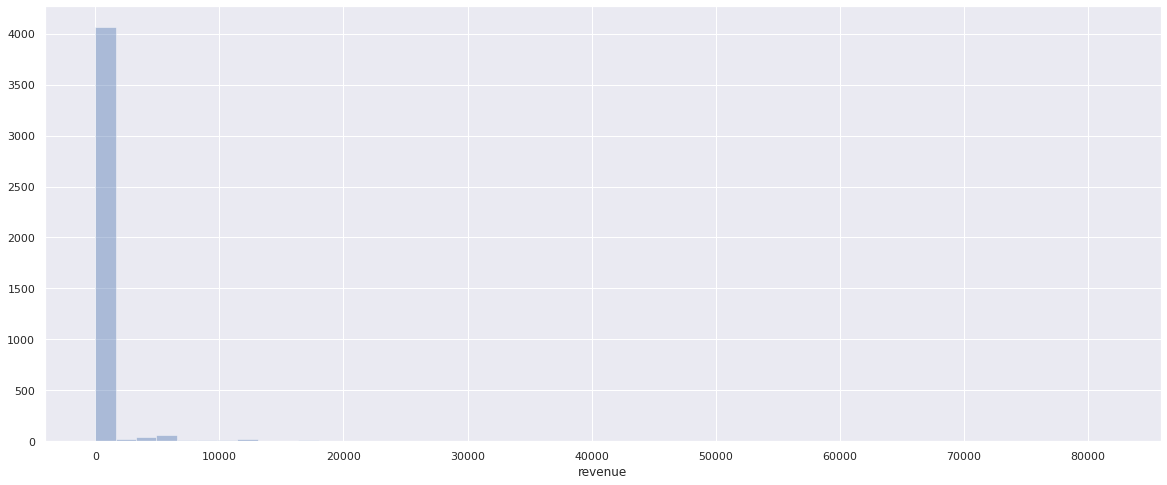

In [53]:
# Посмотрим на распределение во 2 контрольной группе
sns.distplot(data[data['group'] == "control_2"].revenue, kde=False)

**Вывод**: по графикам видно, что распределения в обеих контрольных группах ненормальны за счет наличия выбросов.

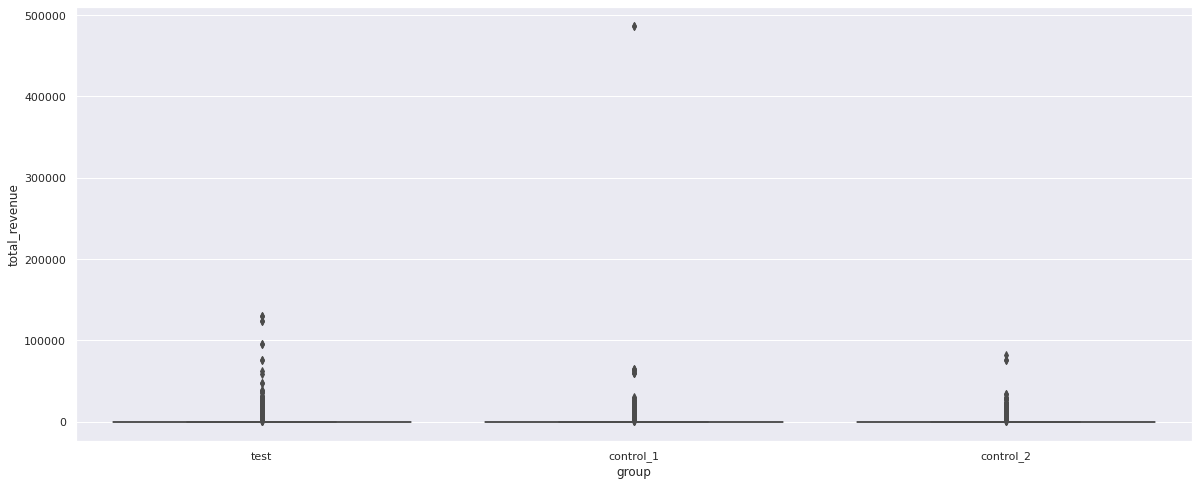

In [54]:
# Построим боксплот
sns.boxplot(x="group", y="total_revenue", data=data)

**Вывод**: мы видим наличие выбросов во всех группах. Однако, удалять их не будем в связи с возможной их большой значимостью.

Проверим гомогенность дисперсий при помощи критерия Левена.

Нулевая гипотеза - дисперсии двух групп не отличаются.
Альтернативная гипотеза - дисперсии двух групп статистически значимо отличаются.

In [55]:
ss.levene(data[data['group'] == "control_1"].revenue, data[data['group'] == "control_2"].revenue)

LeveneResult(statistic=1.8231884520795034, pvalue=0.1769695950167344)

**Вывод**: при проверке гомогенности дисперсий при помощи критерия Левена pvalue>0.05, что говорит о том, что мы не можем отклонить нулевую гипотезу, т.е. дисперсии двух групп не отличаются.

Таким образом, при проведении A/А теста будем использовать Т-критерий Стьюдента, т.к. мы подтвердили требование гомогенности дисперсий и у нас большое число наблюдений (несмотря на то, что распределения ненормальны). Оценивать сплит-систему будем при помощи FPR.

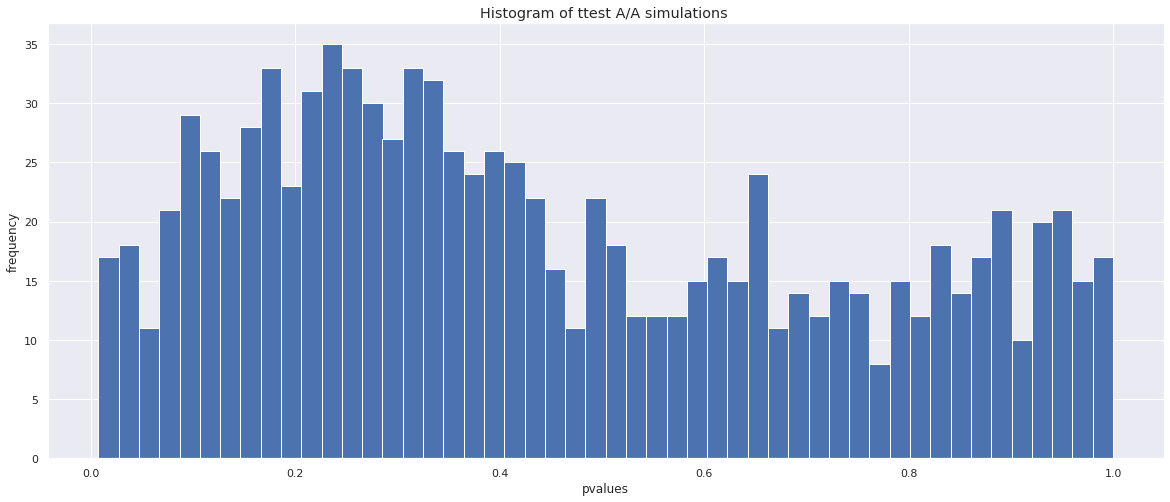

0.035

In [56]:
# Проведем  A/A тест

n = 100000
simulations = 1000
n_s = 1000
res = []

# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = data[data['group'] == "control_1"].sample(n_s, replace=False).revenue.values
    s2 = data[data['group'] == "control_2"].sample(n_s, replace=False).revenue.values
    res.append(stats.ttest_ind(s1, s2, equal_var=False)[1])  # сохраняем pvalue

plt.hist(res, bins=50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, превышает ли количество ложноположительных случаев альфа
sum(np.array(res) < 0.05) / simulations

**Вывод:** FPR не превышает заданный уровень альфа(0,05). Сплит-система работает корректно. 

**ARPPU по подписке premium_no_trial**

In [57]:
# ARPPU
data_arppu = data.query("(total_revenue>0) & (premium_no_trial==1)")

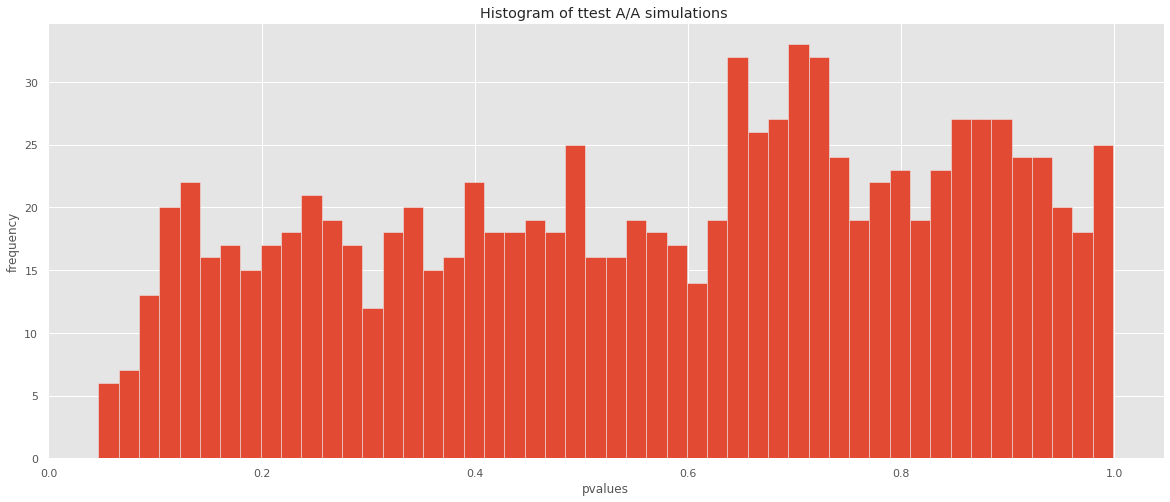

0.001

In [58]:
# Проведем  A/A тест

n = 100000
simulations = 1000
n_s = 50
res = []

# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = data_arppu[data_arppu['group'] == "control_1"].sample(n_s, replace=False).revenue.values
    s2 = data_arppu[data_arppu['group'] == "control_2"].sample(n_s, replace=False).revenue.values
    res.append(stats.ttest_ind(s1, s2, equal_var=False)[1])  # сохраняем pvalue

plt.hist(res, bins=50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, превышает ли количество ложноположительных случаев альфа
sum(np.array(res) < 0.05) / simulations

**Вывод:** FPR не превышает заданный уровень альфа(0,05). Сплит-система работает корректно. 

**CR**

В связи с тем, что конверсия - категориальная переменаая, воспользуемся критерием Хи-квадрат.

Нулевая гипотеза - две иконтрольные группы статистически значимо не отличаются по CR.

Альтернативная гипотеза - две контрольные группы статистически значимо отличаются по CR.

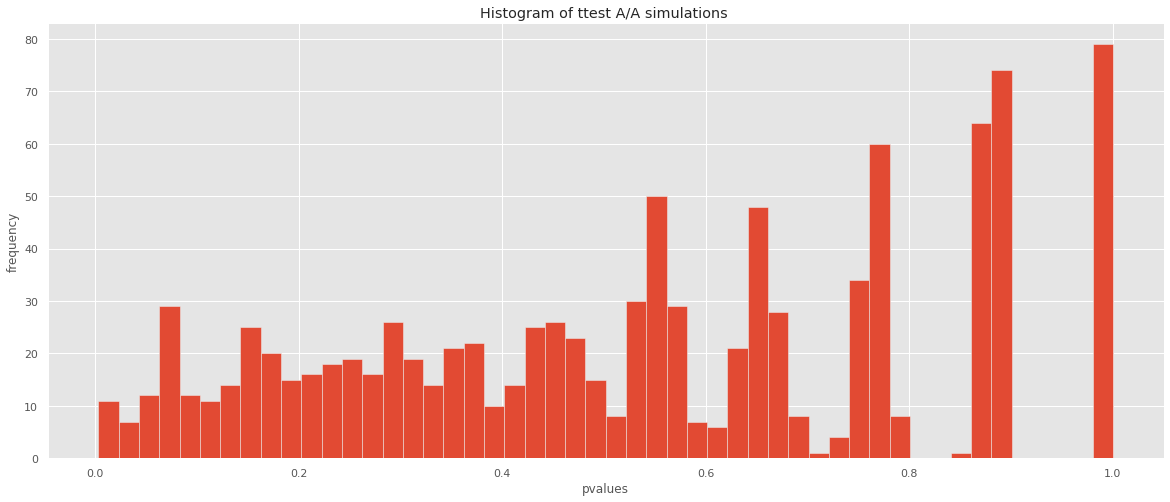

0.023

In [59]:
# Проведем  A/A тест

n = 100000
simulations = 1000
n_s = 1000
res = []

# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = data[data['group'] == "control_1"].premium_no_trial.sample(n_s, replace=False).values
    s2 = data[data['group'] == "control_2"].premium_no_trial.sample(n_s, replace=False).values
    ab = np.array([[s1.sum(), s1.shape[0] - s1.sum()], [s2.sum(), s2.shape[0] - s2.sum()]]) 
    res.append(stats.chi2_contingency(ab, correction=False)[1])  # сохраняем pvalue

plt.hist(res, bins=50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, превышает ли количество ложноположительных случаев альфа
sum(np.array(res) < 0.05) / simulations

**Вывод:** FPR не превышает заданный уровень альфа(0,05). Сплит-система работает корректно. 

**Вывод по А/А тесту**
1. В качестве целевых метрик использовали ARPU, ARPPU и CR (за конверсию принимаем покупку премиум-подписки).
2. В обеих контрольных группах и в тестовой группе имеются выбросы.
2. При помощи критерия Левена подтвердили, что дисперсии гомогенны.
3. Для оценки ARPU и ARPPU выбрали t-тест.
4. Для оценки СR (категориальная переменная) выбрали Хи-квадрат.
5. Оценивали сплит-систему при помощи FPR.
6. Убедились, что сплит-система работает корректно.

## A/B тест

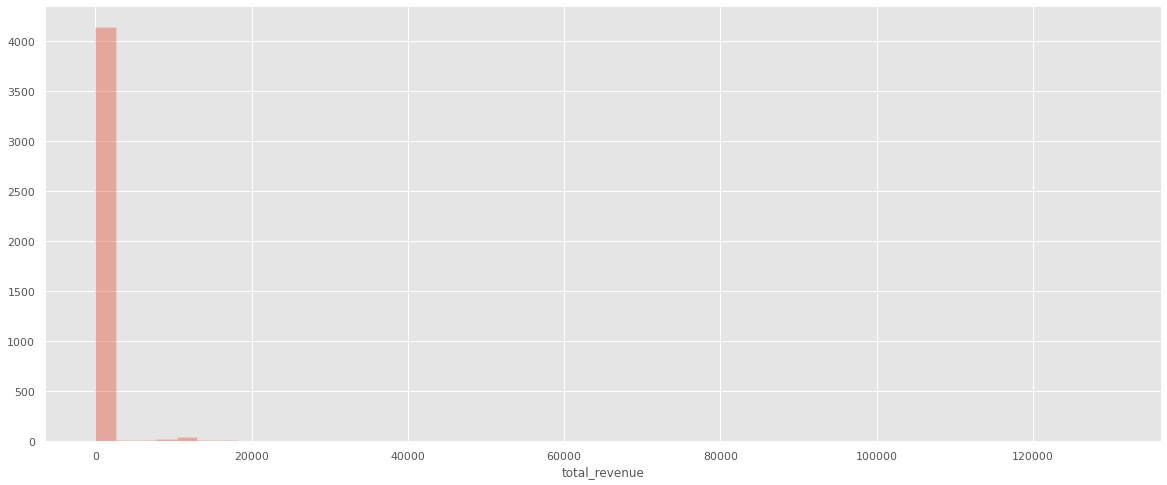

In [60]:
# Посмотрим на распределение в тестовой группе
sns.distplot(data[data['group'] == "test"].total_revenue, kde=False)

**Вывод**: по графику видно, что распределение в тестовой группе ненормальное, с наличием выбросов. Для дальнейшего сравнения объединим 2 контрольные группы в одну, т.к. мы доказали, что сплит-система сработала корректно.

In [61]:
# Напишем функции для подсчета ARPU, ARPPU и CR
def group_arpu(df):
    arpu_control = df[df.group != 'test'].revenue.sum() / df[df.group != 'test'].uid.nunique()
    arpu_test = df[df.group == 'test'].revenue.sum() / df[df.group == 'test'].uid.nunique()
    display("ARPU для контрольных групп:", arpu_control)
    display("ARPU для тестовой группы:", arpu_test)
    
def group_arppu(df):
    df_arppu = df.query("premium_no_trial==1")
    arppu_control = df[df.group != 'test'].revenue.sum() / (
        df_arppu[df_arppu.group != 'test'].uid.nunique())
    arppu_test = df_arppu[df_arppu.group == 'test'].revenue.sum() / (df_arppu[df_arppu.group == 'test'].uid.nunique())
    display("ARPPU для контрольных групп:", arppu_control)
    display("ARPPU для тестовой группы:", arppu_test)
    
def group_cr(df):
    cr_control = df[(df.group != 'test') & (df.premium_no_trial == 1)].uid.nunique() / (
        df[df.group != 'test'].uid.nunique())
    cr_test = df[(df.group == 'test') & (df.premium_no_trial == 1)].uid.nunique() / df[df.group == 'test'].uid.nunique()
    display("CR для контрольных групп:", cr_control)
    display("CR для тестовой группы:", cr_test)

**ARPU**

In [62]:
# Посчитаем ARPU для контрольных и тестовой группы
group_arpu(data)

'ARPU для контрольных групп:'

526.7658952781674

'ARPU для тестовой группы:'

546.6635448372747

Мы видим, что ARPU несколько увеличился в тестовой группе, посмотрим, насколько это статистически значимо.

Нулевая гипотеза - тестовая и контрольные группы статистически значимо не отличаются по ARPU.

Альтернативная гипотеза - тестовая и контрольные группы статистически значимо отличаются по ARPU.

In [63]:
# Проведем Т-тест
ttest_ind(data[data.group != 'test'].revenue, data[data.group == 'test'].revenue)

Ttest_indResult(statistic=-0.23465337599060304, pvalue=0.814481492619434)

**Вывод**: pvalue>0.05, следовательно, мы не можем отклонить нулевую гипотезу, т.е. тестовая и контрольные группы статистически значимо не отличаются по ARPU.

**ARPPU по подписке premium_no_trial**

In [64]:
# Посчитаем ARPPU по подписке premium_no_trial для контрольных и тестовой группы
group_arppu(data)

'ARPPU для контрольных групп:'

22535.045

'ARPPU для тестовой группы:'

12187.10606060606

Мы видим, что ARPPU увеличился в тестовой группе, посмотрим, насколько это статистически значимо.

Нулевая гипотеза - тестовая и контрольные группы статистически значимо не отличаются по ARPPU.

Альтернативная гипотеза - тестовая и контрольные группы статистически значимо отличаются по ARPPU.

In [65]:
# Проведем Т-тест
ttest_ind(data_arppu[data_arppu.group != 'test'].revenue, data_arppu[data_arppu.group == 'test'].revenue)

Ttest_indResult(statistic=-2.532507206884283, pvalue=0.011905017482852612)

**Вывод**: pvalue<0.05, следовательно, мы можем отклонить нулевую гипотезу, т.е. тестовая и контрольные группы статистически значимо отличаются по ARPPU.

**CR**

In [66]:
# Посчитаем конверсию в контрольных и тестовой группах
group_cr(data)

'CR для контрольных групп:'

0.02337540906965872

'CR для тестовой группы:'

0.015453055490517443

Мы видим, что конверсия в подписку premium_no_trial уменьшилась в тестовой группе. Посмотрим, насколько это статистически значимо.


Для оценки конверсии воспользуемся критерием Хи-квадрат.

Нулевая гипотеза - тестовая и контрольные группы статистически значимо не отличаются по CR.

Альтернативная гипотеза - тестовая и контрольные группы статистически значимо отличаются по CR.

In [67]:
a = data[data['group'] != 'test'].premium_no_trial
b = data[data['group'] == 'test'].premium_no_trial
ab = np.array([[a.sum(), a.shape[0] - a.sum()], [b.sum(), b.shape[0] - b.sum()]]) 
stats.chi2_contingency(ab, correction=False)[1]

0.003289519509343992

**Вывод**: pvalue<0.05, следовательно, мы можем отклонить нулевую гипотезу, т.е. тестовая и контрольные группы статистически значимо отличаются по CR.

**Вывод по A/B тесту**: 
1. Распределение выручки в тестовой группе, как и в обеих контрольных группах, ненормально за счет наличия выбросов.
2. Оценивали так же ARPU и ARPPU при помощи t-теста и СR при помощи Хи-квадрата.
3. Выяснили, что тестовая и контрольные группы статистически значимо не отличаются по ARPU, при этом имеется ститастически значимая разница групп по ARPPU (ARPPU увеличился) и по CR(конверсия снизилась). Можем предположить, что подписка подорожала, т.к. произошло снижение конверсии, компенсируемое выручкой.
4. Считаю, что для всей аудитории приложения эксперимент по изменению стоимости подписки Premium_no_trial оказался неуспешным.

## Анализ конкретных групп пользователей

Проанализируем, имеет ли нововведение смысл среди каких-либо конкретных групп пользователей.

Сначала посмотрим, в каких группах пользователей мы видим прирост выручки и далее проверим стат значимость изменений ARPU и ARPPU при помощи bootstrap (он более устойчив к выбросам и небольшому числу наблюдений, а при выборе конкретной группы пользователей количество наблюдений снижается), CR в подписку premium_no_trial при помощи Хи-квадрата.

In [68]:
# Посмотрим на выручку в различных странах во всех группах
data_countries = data.groupby(['country', 'group'], as_index=False) \
    .agg({'revenue': 'sum'}) \
    .query("revenue>0") 
data_countries_pivot = data_countries.pivot(index='country', columns='group', values='revenue')
    
data_countries.head()

,country,group,revenue
0,Argentina,control_1,144690.0
1,Argentina,control_2,121017.0
2,Argentina,test,188019.0
3,Australia,control_1,18304.0
4,Australia,control_2,22646.0


In [69]:
# Найдем разницу в выручке между контрольными группами и тестовой
# Отсортируем сначала по убыванию разницы в выручке между тестовой и первой контрольной группой
data_countries_pivot['test_control_1'] = data_countries_pivot.test - data_countries_pivot.control_1
data_countries_pivot['test_control_2'] = data_countries_pivot.test - data_countries_pivot.control_2
data_countries_pivot.sort_values(by='test_control_1', ascending=False).head()

group,control_1,control_2,test,test_control_1,test_control_2
country,,,,,
Spain,99060.0,193778.0,285428.0,186368.0,91650.0
United Arab Emirates,75543.0,117143.0,213785.0,138242.0,96642.0
France,184353.0,149071.0,297700.0,113347.0,148629.0
Germany,23998.0,71409.0,96096.0,72098.0,24687.0
Argentina,144690.0,121017.0,188019.0,43329.0,67002.0


In [70]:
# Отсортируем по убыванию разницы в выручке между тестовой и второй контрольной группой
data_countries_pivot.sort_values(by='test_control_2', ascending=False).head()

group,control_1,control_2,test,test_control_1,test_control_2
country,,,,,
France,184353.0,149071.0,297700.0,113347.0,148629.0
United States of America,743951.0,584207.0,721838.0,-22113.0,137631.0
United Arab Emirates,75543.0,117143.0,213785.0,138242.0,96642.0
Spain,99060.0,193778.0,285428.0,186368.0,91650.0
Argentina,144690.0,121017.0,188019.0,43329.0,67002.0


**Вывод:** мы видим, что в некоторых странах выручка выросла (особенно ОАЭ, Испании, Франции), а в некоторых странах даже стала отрицательной. 


In [71]:
# Отберем отдельно Францию, ОАЭ и Испанию
data_France = data.query('country == "France"')
data_OAE = data.query('country == "United Arab Emirates"')
data_Spain = data.query('country == "Spain"')

In [72]:
# Посмотрим на метрики во Франции
group_arpu(data_France)
group_arppu(data_France)
group_cr(data_France)

'ARPU для контрольных групп:'

446.9490616621984

'ARPU для тестовой группы:'

829.2479108635098

'ARPPU для контрольных групп:'

16671.2

'ARPPU для тестовой группы:'

10016.5

'CR для контрольных групп:'

0.02680965147453083

'CR для тестовой группы:'

0.011142061281337047

**Вывод:** Мы видим, что в тестовой группе во Франции ARPU, ARPPU выросли, CR снизился.

In [73]:
# Посмотрим на метрики в ОАЭ
group_arpu(data_OAE)
group_arppu(data_OAE)
group_cr(data_OAE)

'ARPU для контрольных групп:'

460.9712918660287

'ARPU для тестовой группы:'

945.9513274336283

'ARPPU для контрольных групп:'

27526.571428571428

'ARPPU для тестовой группы:'

27326.0

'CR для контрольных групп:'

0.01674641148325359

'CR для тестовой группы:'

0.02654867256637168

**Вывод:** Мы видим, что в тестовой группе в ОАЭ ARPU, ARPPU и CR выросли.

In [74]:
# Посмотрим на метрики в Испании
group_arpu(data_Spain)
group_arppu(data_Spain)
group_cr(data_Spain)

'ARPU для контрольных групп:'

449.13803680981596

'ARPU для тестовой группы:'

948.2657807308971

'ARPPU для контрольных групп:'

19522.533333333333

'ARPPU для тестовой группы:'

24918.833333333332

'CR для контрольных групп:'

0.023006134969325152

'CR для тестовой группы:'

0.019933554817275746

**Вывод:** Мы видим, что в тестовой группе в Испании ARPU, ARPPU выросли, CR снизился.

Проверим изменения метрик в ОАЭ, Испании, Франции на стат. значимость.

In [75]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа
def get_bootstrap(
    data_column_1,  # числовые значения первой выборки
    data_column_2,  # числовые значения второй выборки
    boot_it=1000,  # количество бутстрэп-подвыборок
    statistic=np.mean,  # интересующая нас статистика
    bootstrap_conf_level=0.95  # уровень значимости
):
    boot_data = []
    for i in tqdm(range(boot_it)):  # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            len(data_column_1), 
            replace=True  # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            len(data_column_1), 
            replace=True
        ).values
        
        boot_data.append(statistic(samples_1) - statistic(samples_2))  # mean() - применяем статистику

    
    p_1 = norm.cdf(
        x=0, 
        loc=np.mean(boot_data), 
        scale=np.std(boot_data)
    )
    p_2 = norm.cdf(
        x=0, 
        loc=-np.mean(boot_data), 
        scale=np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
       
    return p_value

Нулевая гипотеза - тестовая и контрольные группы во Франции статистически значимо не отличаются по ARPU.

Альтернативная гипотеза - тестовая и контрольные группы во Франции статистически значимо отличаются по ARPU.

In [76]:
get_bootstrap(
    data_France[data_France.group != 'test'].revenue,
    data_France[data_France.group == 'test'].revenue,
    boot_it=1000,  # количество бутстрэп-подвыборок
    statistic=np.mean,  # интересующая нас статистика
    bootstrap_conf_level=0.95  # уровень значимости
)

0.048762064616731216

Нулевая гипотеза - тестовая и контрольные группы во Франции статистически значимо не отличаются по ARPPU.

Альтернативная гипотеза - тестовая и контрольные группы во Франции статистически значимо отличаются по ARPPU.

In [77]:
get_bootstrap(
    data_arppu[(data_arppu.country == "France") & (data_arppu.group != 'test')].revenue,
    data_arppu[(data_arppu.country == "France") & (data_arppu.group == 'test')].revenue,
    boot_it=1000,  # количество бутстрэп-подвыборок
    statistic=np.mean,  # интересующая нас статистика
    bootstrap_conf_level=0.95  # уровень значимости
)

0.005864682216348145

Нулевая гипотеза - тестовая и контрольные группы во Франции статистически значимо не отличаются по конверсии в покупку подписки premium_no_trial.

Альтернативная гипотеза - тестовая и контрольные группы во Франции статистически значимо отличаются по конверсии в покупку подписки premium_no_trial.

In [78]:
a = data_France[data_France['group'] != 'test'].premium_no_trial
b = data_France[data_France['group'] == 'test'].premium_no_trial
ab = np.array([[a.sum(), a.shape[0] - a.sum()], [b.sum(), b.shape[0] - b.sum()]]) 
stats.chi2_contingency(ab, correction=False)[1]

0.0947346679690594

Нулевая гипотеза - тестовая и контрольные группы в ОАЭ статистически значимо не отличаются по ARPU.

Альтернативная гипотеза - тестовая и контрольные группы в ОАЭ статистически значимо отличаются по ARPU.

In [79]:
get_bootstrap(
    data_OAE[data_OAE.group != 'test'].revenue,
    data_OAE[data_OAE.group == 'test'].revenue,
    boot_it=1000,  # количество бутстрэп-подвыборок
    statistic=np.mean,  # интересующая нас статистика
    bootstrap_conf_level=0.95  # уровень значимости
)

0.2920326866144982

Нулевая гипотеза - тестовая и контрольные группы в ОАЭ статистически значимо не отличаются по ARPPU.

Альтернативная гипотеза - тестовая и контрольные группы в ОАЭ статистически значимо отличаются по ARPPU.

In [80]:
get_bootstrap(
    data_arppu[(data_arppu.country == "United Arab Emirates") & (data_arppu.group != 'test')].revenue,
    data_arppu[(data_arppu.country == "United Arab Emirates") & (data_arppu.group == 'test')].revenue,
    boot_it=1000,  # количество бутстрэп-подвыборок
    statistic=np.mean,  # интересующая нас статистика
    bootstrap_conf_level=0.95  # уровень значимости
)

0.5236329739662124

Нулевая гипотеза - тестовая и контрольные группы в ОАЭ статистически значимо не отличаются по конверсии в покупку подписки premium_no_trial.

Альтернативная гипотеза - тестовая и контрольные группы в ОАЭ статистически значимо отличаются по конверсии в покупку подписки premium_no_trial.

In [81]:
a = data_OAE[data_OAE['group'] != 'test'].premium_no_trial
b = data_OAE[data_OAE['group'] == 'test'].premium_no_trial
ab = np.array([[a.sum(), a.shape[0] - a.sum()], [b.sum(), b.shape[0] - b.sum()]]) 
stats.chi2_contingency(ab, correction=False)[1]

0.39822899172693005

Нулевая гипотеза - тестовая и контрольные группы в Испании статистически значимо не отличаются по ARPU.

Альтернативная гипотеза - тестовая и контрольные группы в Испании статистически значимо отличаются по ARPU.

In [82]:
get_bootstrap(
    data_Spain[data_Spain.group != 'test'].revenue,
    data_Spain[data_Spain.group == 'test'].revenue,
    boot_it=1000,  # количество бутстрэп-подвыборок
    statistic=np.mean,  # интересующая нас статистика
    bootstrap_conf_level=0.95  # уровень значимости
)

0.09082603960787757

Нулевая гипотеза - тестовая и контрольные группы в Испании статистически значимо не отличаются по ARPPU.

Альтернативная гипотеза - тестовая и контрольные группы в Испании статистически значимо отличаются по ARPPU.

In [83]:
get_bootstrap(
    data_arppu[(data_arppu.country == "Spain") & (data_arppu.group != 'test')].revenue,
    data_arppu[(data_arppu.country == "Spain") & (data_arppu.group == 'test')].revenue,
    boot_it=1000,  # количество бутстрэп-подвыборок
    statistic=np.mean,  # интересующая нас статистика
    bootstrap_conf_level=0.95  # уровень значимости
)

0.1769842865418485

Нулевая гипотеза - тестовая и контрольные группы в Испании статистически значимо не отличаются по конверсии в покупку подписки premium_no_trial.

Альтернативная гипотеза - тестовая и контрольные группы в Испании статистически значимо отличаются по конверсии в покупку подписки premium_no_trial.

In [84]:
a = data_Spain[data_Spain['group'] != 'test'].premium_no_trial
b = data_Spain[data_Spain['group'] == 'test'].premium_no_trial
ab = np.array([[a.sum(), a.shape[0] - a.sum()], [b.sum(), b.shape[0] - b.sum()]]) 
stats.chi2_contingency(ab, correction=False)[1]

0.7704286284753816

**Вывод по странам**:
1. Во Франции статистически значимо повышение ARPU и ARPPU, снижение конверсии статистически не значимо.
2. В ОАЭ и в Испании изменения метрик статистически незначимы.

Таким образом, можно попробовать распространить нововведение среди французов.

**Посмотрим, изменения метрик в распределении по полу.**

In [85]:
data.gender.value_counts()

1    12359
0      576
Name: gender, dtype: int64

In [86]:
# Отберем пользователей по полу
gender_0 = data.query('gender == 0')
gender_1 = data.query('gender == 1')

In [87]:
# Посмотрим на метрики среди пола 0
group_arpu(gender_0)
group_arppu(gender_0)
group_cr(gender_0)

'ARPU для контрольных групп:'

229.43617021276594

'ARPU для тестовой группы:'

135.395

'ARPPU для контрольных групп:'

17253.6

'ARPPU для тестовой группы:'

nan

'CR для контрольных групп:'

0.013297872340425532

'CR для тестовой группы:'

0.0

In [88]:
# Посмотрим на метрики среди пола 1
group_arpu(gender_1)
group_arppu(gender_1)
group_cr(gender_1)

'ARPU для контрольных групп:'

540.4328850855745

'ARPU для тестовой группы:'

566.8683370179317

'ARPPU для контрольных групп:'

22670.466666666667

'ARPPU для тестовой группы:'

12187.10606060606

'CR для контрольных групп:'

0.023838630806845965

'CR для тестовой группы:'

0.016212232866617538

Мы видим, что: 
1. среди пола 0 ARPU и СR несколько снизились. ARPPU в тестовой группе не определяется, следовательно, среди пола 0 в тестовой группе никто не купил подписку premium_no_trial.
2. среди пола 1 ARPU и ARPPU увеличились, конверсия снизилась.

Нулевая гипотеза - тестовая и контрольные группы среди пола 0 статистически значимо не отличаются по ARPU.

Альтернативная гипотеза - тестовая и контрольные группы среди пола 0 статистически значимо отличаются по ARPU.

In [89]:
get_bootstrap(
    gender_0[gender_0.group != 'test'].revenue,
    gender_0[gender_0.group == 'test'].revenue,
    boot_it=1000,  # количество бутстрэп-подвыборок
    statistic=np.mean,  # интересующая нас статистика
    bootstrap_conf_level=0.95  # уровень значимости
)

0.3842255824965821

Нулевая гипотеза - тестовая и контрольные группы среди пола 0 статистически значимо не отличаются по конверсии в покупку подписки premium_no_trial.

Альтернативная гипотеза - тестовая и контрольные группы среди пола 0 статистически значимо отличаются по конверсии в покупку подписки premium_no_trial.

In [90]:
a = gender_0[gender_0['group'] != 'test'].premium_no_trial
b = gender_0[gender_0['group'] == 'test'].premium_no_trial
ab = np.array([[a.sum(), a.shape[0] - a.sum()], [b.sum(), b.shape[0] - b.sum()]]) 
stats.chi2_contingency(ab, correction=False)[1]

0.10143320652914367

Нулевая гипотеза - тестовая и контрольные группы среди пола 1 статистически значимо не отличаются по ARPU.

Альтернативная гипотеза - тестовая и контрольные группы среди пола 1 статистически значимо отличаются по ARPU.

In [91]:
get_bootstrap(
    gender_1[gender_1.group != 'test'].revenue,
    gender_1[gender_1.group == 'test'].revenue,
    boot_it=1000,  # количество бутстрэп-подвыборок
    statistic=np.mean,  # интересующая нас статистика
    bootstrap_conf_level=0.95  # уровень значимости
)

0.6731170427614278

Нулевая гипотеза - тестовая и контрольные группы среди пола 1 статистически значимо не отличаются по ARPPU.

Альтернативная гипотеза - тестовая и контрольные группы среди пола 1 статистически значимо отличаются по ARPPU.

In [92]:
get_bootstrap(
    data_arppu[(data_arppu.gender == 1) & (data_arppu.group != 'test')].revenue,
    data_arppu[(data_arppu.gender == 1) & (data_arppu.group == 'test')].revenue,
    boot_it=1000,  # количество бутстрэп-подвыборок
    statistic=np.mean,  # интересующая нас статистика
    bootstrap_conf_level=0.95  # уровень значимости
)

0.004039609849791206

Нулевая гипотеза - тестовая и контрольные группы среди пола 1 статистически значимо не отличаются по конверсии в покупку подписки premium_no_trial.

Альтернативная гипотеза - тестовая и контрольные группы среди пола 1 статистически значимо отличаются по конверсии в покупку подписки premium_no_trial.

In [93]:
a = gender_1[gender_1['group'] != 'test'].premium_no_trial
b = gender_1[gender_1['group'] == 'test'].premium_no_trial
ab = np.array([[a.sum(), a.shape[0] - a.sum()], [b.sum(), b.shape[0] - b.sum()]]) 
stats.chi2_contingency(ab, correction=False)[1]

0.006437392913578089

**Вывод по полу**:
1. Среди пола 0 изменения метрик статистически незначимы.
2. Среди пола 1 статистически значимо повышение ARPPU и снижение конверсии.

Таким образом, распространять нововведение среди какого-либо пола не стоит.

**Посмотрим на изменения метрик в распределении по возрасту**

In [94]:
# Посмотрим, сколько пользователей в каждой категории
data.age_category.value_counts()

молодые            4887
юные               3934
средний возраст    2656
зрелые             1388
пожилые              70
Name: age_category, dtype: int64

In [95]:
# Отберем пользователей по возрасту
data_16_25 = data.query('age_category == "юные"')
data_26_35 = data.query('age_category == "молодые"')
data_36_45 = data.query('age_category == "средний возраст"')
data_46_60 = data.query('age_category == "зрелые"')
data_61_99 = data.query('age_category == "пожилые"')

In [96]:
# Посмотрим на метрики среди юных
group_arpu(data_16_25)
group_arppu(data_16_25)
group_cr(data_16_25)

'ARPU для контрольных групп:'

626.5940138142747

'ARPU для тестовой группы:'

451.55409582689333

'ARPPU для контрольных групп:'

23665.27536231884

'ARPPU для тестовой группы:'

8817.545454545454

'CR для контрольных групп:'

0.026477359938603222

'CR для тестовой группы:'

0.017001545595054096

In [97]:
# Посмотрим на метрики среди молодых
group_arpu(data_26_35)
group_arppu(data_26_35)
group_cr(data_26_35)

'ARPU для контрольных групп:'

505.55195007800313

'ARPU для тестовой группы:'

573.1011578305911

'ARPPU для контрольных групп:'

20003.62962962963

'ARPPU для тестовой группы:'

13940.333333333334

'CR для контрольных групп:'

0.02527301092043682

'CR для тестовой группы:'

0.012797074954296161

In [98]:
# Посмотрим на метрики среди среднего возраста
group_arpu(data_36_45)
group_arppu(data_36_45)
group_cr(data_36_45)

'ARPU для контрольных групп:'

444.45506257110355

'ARPU для тестовой группы:'

692.62100456621

'ARPPU для контрольных групп:'

23677.333333333332

'ARPPU для тестовой группы:'

13812.117647058823

'CR для контрольных групп:'

0.01877133105802048

'CR для тестовой группы:'

0.019406392694063926

In [99]:
# Посмотрим на метрики среди зрелых
group_arpu(data_46_60)
group_arppu(data_46_60)
group_cr(data_46_60)

'ARPU для контрольных групп:'

482.29175475687106

'ARPU для тестовой группы:'

360.3972286374134

'ARPPU для контрольных групп:'

30416.533333333333

'ARPPU для тестовой группы:'

12300.6

'CR для контрольных групп:'

0.015856236786469344

'CR для тестовой группы:'

0.011547344110854504

In [100]:
# Посмотрим на метрики среди пожилых
group_arpu(data_61_99)
group_arppu(data_61_99)
group_cr(data_61_99)

'ARPU для контрольных групп:'

395.390243902439

'ARPU для тестовой группы:'

1749.7037037037037

'ARPPU для контрольных групп:'

8105.5

'ARPPU для тестовой группы:'

21307.0

'CR для контрольных групп:'

0.04878048780487805

'CR для тестовой группы:'

0.037037037037037035

**Вывод:**
1. Среди юных все показатели снизились.
2. Среди молодых ARPU, ARPPU увеличились, а конверсия снизилась.
3. Среди пользователей среднего возраста все показатели увеличились (конвесрия незначительно).
4. Среди пользователей зрелого возраста конверсия не изменилась, ARPU снизился, ARPPU увеличился.
5. Среди пожилых ARPU, ARPPU увеличились, а конверсия снизилась.

Нулевая гипотеза - тестовая и контрольные группы среди юных статистически значимо не отличаются по ARPU.

Альтернативная гипотеза - тестовая и контрольные группы среди юных статистически значимо отличаются по ARPU.

In [101]:
get_bootstrap(
    data_16_25[data_16_25.group != 'test'].revenue,
    data_16_25[data_16_25.group == 'test'].revenue,
    boot_it=1000,  # количество бутстрэп-подвыборок
    statistic=np.mean,  # интересующая нас статистика
    bootstrap_conf_level=0.95  # уровень значимости
)

0.3735451548120411

Нулевая гипотеза - тестовая и контрольные группы среди юных статистически значимо не отличаются по ARPPU.

Альтернативная гипотеза - тестовая и контрольные группы среди юных статистически значимо отличаются по ARPPU.

In [102]:
get_bootstrap(
    data_arppu[(data_arppu.age_category == "юные") & (data_arppu.group != 'test')].revenue,
    data_arppu[(data_arppu.age_category == "юные") & (data_arppu.group == 'test')].revenue,
    boot_it=1000,  # количество бутстрэп-подвыборок
    statistic=np.mean,  # интересующая нас статистика
    bootstrap_conf_level=0.95  # уровень значимости
)

0.7956823230396866

Нулевая гипотеза - тестовая и контрольные группы среди юных статистически значимо не отличаются по конверсии в покупку подписки premium_no_trial.

Альтернативная гипотеза - тестовая и контрольные группы среди юных статистически значимо отличаются по конверсии в покупку подписки premium_no_trial.

In [103]:
a = data_16_25[data_16_25['group'] != 'test'].premium_no_trial
b = data_16_25[data_16_25['group'] == 'test'].premium_no_trial
ab = np.array([[a.sum(), a.shape[0] - a.sum()], [b.sum(), b.shape[0] - b.sum()]]) 
stats.chi2_contingency(ab, correction=False)[1]

0.06657975778938208

Нулевая гипотеза - тестовая и контрольные группы среди молодых статистически значимо не отличаются по ARPU.

Альтернативная гипотеза - тестовая и контрольные группы среди молодых статистически значимо отличаются по ARPU.

In [104]:
get_bootstrap(
    data_26_35[data_26_35.group != 'test'].revenue,
    data_26_35[data_26_35.group == 'test'].revenue,
    boot_it=1000,  # количество бутстрэп-подвыборок
    statistic=np.mean,  # интересующая нас статистика
    bootstrap_conf_level=0.95  # уровень значимости
)

0.43616721141824355

Нулевая гипотеза - тестовая и контрольные группы среди молодых статистически значимо не отличаются по ARPPU.

Альтернативная гипотеза - тестовая и контрольные группы среди молодых  статистически значимо отличаются по ARPPU.

In [105]:
get_bootstrap(
    data_arppu[(data_arppu.age_category == "молодые") & (data_arppu.group != 'test')].revenue,
    data_arppu[(data_arppu.age_category == "молодые") & (data_arppu.group == 'test')].revenue,
    boot_it=1000,  # количество бутстрэп-подвыборок
    statistic=np.mean,  # интересующая нас статистика
    bootstrap_conf_level=0.95  # уровень значимости
)

0.01548860214472227

Нулевая гипотеза - тестовая и контрольные группы среди молодых статистически значимо не отличаются по конверсии в покупку подписки premium_no_trial.

Альтернативная гипотеза - тестовая и контрольные группы среди молодых статистически значимо отличаются по конверсии в покупку подписки premium_no_trial.

In [106]:
a = data_26_35[data_26_35['group'] != 'test'].premium_no_trial
b = data_26_35[data_26_35['group'] == 'test'].premium_no_trial
ab = np.array([[a.sum(), a.shape[0] - a.sum()], [b.sum(), b.shape[0] - b.sum()]]) 
stats.chi2_contingency(ab, correction=False)[1]

0.004575205991097552

Нулевая гипотеза - тестовая и контрольные группы среди пользователей среднего возраста статистически значимо не отличаются по ARPU.

Альтернативная гипотеза - тестовая и контрольные группы среди пользователей среднего возраста статистически значимо отличаются по ARPU.

In [107]:
get_bootstrap(
    data_36_45[data_36_45.group != 'test'].revenue,
    data_36_45[data_36_45.group == 'test'].revenue,
    boot_it=1000,  # количество бутстрэп-подвыборок
    statistic=np.mean,  # интересующая нас статистика
    bootstrap_conf_level=0.95  # уровень значимости
)

0.049264520271078124

Нулевая гипотеза - тестовая и контрольные группы среди пользователей среднего возраста статистически значимо не отличаются по ARPPU.

Альтернативная гипотеза - тестовая и контрольные группы среди пользователей среднего возраста статистически значимо отличаются по ARPPU.

In [108]:
get_bootstrap(
    data_arppu[(data_arppu.age_category == "средний возраст") & (data_arppu.group != 'test')].revenue,
    data_arppu[(data_arppu.age_category == "средний возраст") & (data_arppu.group == 'test')].revenue,
    boot_it=1000,  # количество бутстрэп-подвыборок
    statistic=np.mean,  # интересующая нас статистика
    bootstrap_conf_level=0.95  # уровень значимости
)

0.09173166190061235

Нулевая гипотеза - тестовая и контрольные группы среди пользователей среднего возраста статистически значимо не отличаются по конверсии в покупку подписки premium_no_trial.

Альтернативная гипотеза - тестовая и контрольные группы среди пользователей среднего возраста статистически значимо отличаются по конверсии в покупку подписки premium_no_trial.

In [109]:
a = data_36_45[data_36_45['group'] != 'test'].premium_no_trial
b = data_36_45[data_36_45['group'] == 'test'].premium_no_trial
ab = np.array([[a.sum(), a.shape[0] - a.sum()], [b.sum(), b.shape[0] - b.sum()]]) 
stats.chi2_contingency(ab, correction=False)[1]

0.9089731496845921

Нулевая гипотеза - тестовая и контрольные группы среди зрелых статистически значимо не отличаются по ARPU.

Альтернативная гипотеза - тестовая и контрольные группы среди зрелых  статистически значимо отличаются по ARPU.

In [110]:
get_bootstrap(
    data_46_60[data_46_60.group != 'test'].revenue,
    data_46_60[data_46_60.group == 'test'].revenue,
    boot_it=1000,  # количество бутстрэп-подвыборок
    statistic=np.mean,  # интересующая нас статистика
    bootstrap_conf_level=0.95  # уровень значимости
)

0.3261035825079869

Нулевая гипотеза - тестовая и контрольные группы среди зрелых статистически значимо не отличаются по ARPPU.

Альтернативная гипотеза - тестовая и контрольные группы среди зрелых статистически значимо отличаются по ARPPU.

In [111]:
get_bootstrap(
    data_arppu[(data_arppu.age_category == "зрелые") & (data_arppu.group != 'test')].revenue,
    data_arppu[(data_arppu.age_category == "зрелые") & (data_arppu.group == 'test')].revenue,
    boot_it=1000,  # количество бутстрэп-подвыборок
    statistic=np.mean,  # интересующая нас статистика
    bootstrap_conf_level=0.95  # уровень значимости
)

1.011094495726359e-118

Нулевая гипотеза - тестовая и контрольные группы среди зрелых статистически значимо не отличаются по конверсии в покупку подписки premium_no_trial.

Альтернативная гипотеза - тестовая и контрольные группы среди зрелых статистически значимо отличаются по конверсии в покупку подписки premium_no_trial.

In [112]:
a = data_46_60[data_46_60['group'] != 'test'].premium_no_trial
b = data_46_60[data_46_60['group'] == 'test'].premium_no_trial
ab = np.array([[a.sum(), a.shape[0] - a.sum()], [b.sum(), b.shape[0] - b.sum()]]) 
stats.chi2_contingency(ab, correction=False)[1]

0.542478344554232

Нулевая гипотеза - тестовая и контрольные группы среди пожилых статистически значимо не отличаются по ARPU.

Альтернативная гипотеза - тестовая и контрольные группы среди пожилых статистически значимо отличаются по ARPU.

In [113]:
get_bootstrap(
    data_61_99[data_61_99.group != 'test'].revenue,
    data_61_99[data_61_99.group == 'test'].revenue,
    boot_it=1000,  # количество бутстрэп-подвыборок
    statistic=np.mean,  # интересующая нас статистика
    bootstrap_conf_level=0.95  # уровень значимости
)

0.19640632273636016

Нулевая гипотеза - тестовая и контрольные группы среди пожилых статистически значимо не отличаются по ARPPU.

Альтернативная гипотеза - тестовая и контрольные группы среди пожилых статистически значимо отличаются по ARPPU.

In [114]:
get_bootstrap(
    data_arppu[(data_arppu.age_category == "пожилые") & (data_arppu.group != 'test')].revenue,
    data_arppu[(data_arppu.age_category == "пожилые") & (data_arppu.group == 'test')].revenue,
    boot_it=1000,  # количество бутстрэп-подвыборок
    statistic=np.mean,  # интересующая нас статистика
    bootstrap_conf_level=0.95  # уровень значимости
)

0.0

Нулевая гипотеза - тестовая и контрольные группы среди пожилых статистически значимо не отличаются по конверсии в покупку подписки premium_no_trial.

Альтернативная гипотеза - тестовая и контрольные группы среди пожилых статистически значимо отличаются по конверсии в покупку подписки premium_no_trial.

In [115]:
a = data_61_99[data_61_99['group'] != 'test'].premium_no_trial
b = data_61_99[data_61_99['group'] == 'test'].premium_no_trial
ab = np.array([[a.sum(), a.shape[0] - a.sum()], [b.sum(), b.shape[0] - b.sum()]]) 
stats.chi2_contingency(ab, correction=False)[1]

0.8096160409809592

**Вывод по возрасту**:
1. Среди юных(16-25лет) изменения метрик статистически незначимы.
2. Среди молодых(26-35 лет) статистически значимо повышение ARPPU.
3. Среди пользователей среднего возраста(36-45 лет) изменения метрик статистически незначимы.
4. Среди зрелых(46-60 лет) статистически значимо повышение ARPPU.
5. Среди пожилых (61-99 лет) статистически значимо повышение ARPPU. Однако, к этому возрасту стоит относиться осторожно, тк зрелых пользователей меньше, чем других возрастов, некоторые пользователи могли ошибочно указать возраст, например, 99 лет, к тому же вряд ли приложение знакомств пользуется популярностью среди пожилых людей.

Таким образом, нововведение можно пробовать распространять среди пользователей 26-35 лет и 46-60 лет.

**Вывод по оценке отдельных групп пользователей:**
1. Рассмотрели изменения ARPU, ARPPU, CR в разбивке по странам, полу и возрасту. 
2. Проверили, насколько статистически значимы эти изменения.
3. Выяснили, что среди отдельных групп пользователей нововведение может быть успешным.
4. В разбивке по возрасту выяснили, что нововведение имеет смысл распространять среди пользователей 26-35 лет и 46-60 лет.
5. Также новвоведение может иметь смысл во Франции.

## Итоговый вывод

1. При проведении А/А теста убедились, что сплит-система работает корректно.
2. Выяснили, что тестовая и контрольные группы статистически значимо не отличаются по ARPU, при этом имеется ститастически значимая разница групп по ARPPU (ARPPU увеличился) и по CR(конверсия снизилась). Можем предположить, что подписка подорожала, т.к. произошло снижение конверсии, компенсируемое выручкой. Считаю, что для всей аудитории приложения эксперимент по изменению стоимости подписки Premium_no_trial оказался неуспешным.
3. Проанализировали, что среди отдельных групп пользователей (пользователи 26-35 лет и 46-60 лет, пользователи Франции) нововведение можно применить.